In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os
import cv2
%matplotlib inline

In [181]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_region_of_interest(img, vertices):
    """
    Overlay a blue dashed line over region of interest
    pts – Array of polygons where each polygon is represented as an array of points.
    """
    x_coords =  np.insert(vertices[:,0][:,0], 0, vertices[:,0][-1,0])
    y_coords =  np.insert(vertices[:,0][:,1], 0, vertices[:,0][-1,1])
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    
    ax.imshow(img)
    ax.plot(x_coords, y_coords, 'b--', lw=4)
    plt.show()

def draw_lines(image, lines, color=[255, 0, 0], thickness=5, debug=True):
    img = np.copy(image)
    # points for lines
    ysize = img.shape[0]
    xsize = img.shape[1]
    v_coef = vert_coef
    
    # for removing abnormal slopes
    t_slope_min = 0.1
    t_slope_max = 4.5
    
    left_lines_params = []
    right_lines_params = []
    # sometimes lines is of 'NoneType' (no lines found?)
    try:
        for line in lines:
            for x1,y1,x2,y2 in line:
                # add to corresponding list of line params
                slope, intercept = get_line_params([x1,y1,x2,y2])
                if (slope > t_slope_min) and (slope < t_slope_max):
                    left_lines_params.append([slope, intercept])
                    if debug:
                        # draw orig (debug)
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 2)
                elif (slope < -t_slope_min) and (slope > -t_slope_max):
                    right_lines_params.append([slope, intercept])
                    if debug:
                        # draw orig (debug)
                        cv2.line(img, (x1, y1), (x2, y2), [0,255,0], 2)
        # for left line
        if len(left_lines_params) > 0:
            # calculate averaged parameters for left line
            left_line_slope, left_line_intercept = average_line(left_lines_params)
            # left line
            left_y1 = ysize
            left_x1 = get_x(left_y1, left_line_slope, left_line_intercept)
            left_y2 = int(ysize * v_coef)
            left_x2 = get_x(left_y2, left_line_slope, left_line_intercept)
            # plot them
            cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)

        # for right line
        if len(right_lines_params) > 0:
            # calculate averaged parameters for two lines
            right_line_slope, right_line_intercept = average_line(right_lines_params)
            # right line
            right_y1 = ysize
            right_x1 = get_x(right_y1, right_line_slope, right_line_intercept)
            right_y2 = int(ysize * v_coef)
            right_x2 = get_x(right_y2, right_line_slope, right_line_intercept)
            # plot them
            cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    except Exception:
        pass

    return img

def average_line(lines):
    # takes a list of lines
    # each line: [slope, intercept]
    # returns average slope and intercept
    slope = sum(l[0] for l in lines) / len(lines)
    intercept = sum(l[1] for l in lines) / len(lines)
    return (slope, intercept)

def get_x(y, slope, intercept):
    # calculates x coord for a given y coord
    return int((y - intercept) / slope)

def hough_lines(img, ρ, θ, α, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    ------
    Parameters:
    ρ [rho]
    θ [theta]
    α [threshold]
    """
    lines = cv2.HoughLinesP(img, ρ, θ, α, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img,pot_lines = draw_lines_new(line_img, lines)
    return line_img,pot_lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_line_params(line):
    # receives a vector of [x1, y1, x2, y2] and returns a slope, intercept
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    x = [x1, x2]
    y = [y1, y2]
    slope, intercept = np.polyfit(x, y, deg=1)
    return slope, intercept

# to define region of interest as proportion of image
vert_coef = 0.35
hor_coef = 0.28
def get_roi_vertices(image, vert_coef=0.35, hor_up=0.28, hor_down=0):#voa e od po4
    '''
    this routine returns 4 vertices of the area in front of the car
    for top-down view perspective warp
    '''
    # finding the best region of interest
    y_size, x_size = image.shape[:2]

    # proportion of vertical size before upper line of ROI starts (starting from top)
    v_coef = vert_coef
    v_down = 0.95
    # proportion of horizontal size before upper left point of ROI (starting from left)
    up_left_coef = hor_up
    # proportion of horizontal size before upper right point of ROI (starting from left)
    up_right_coef = 1 - up_left_coef

    low_left_coef = hor_down
    low_right_coef = 1 - low_left_coef

    # defining tuple of 4 points of ROI
    low_left_point = [x_size * low_left_coef, y_size * v_down]
    low_right_point = [x_size * low_right_coef, y_size * v_down]
    up_left_point = [x_size * up_left_coef, y_size * v_coef]
    up_right_point = [x_size * up_right_coef, y_size * v_coef]

    # defining a poly (first and last points are the same to close the poly)
    verts = np.array( [up_left_point, up_right_point, low_right_point, low_left_point], dtype=np.float32)
    verts = np.reshape(verts, (4,1,2))
    return verts
def plotz(img, cmap='gray'):
    plt.imshow(img, cmap=cmap)
    plt.show()
def corners_unwarp(img, vert_coef=0.35, hor_up=0.28, hor_down=0):
    # def corners_unwarp(img, vert_coef=0.63, hor_coef=0.444):
    '''
    this routine unwarps area in front of car into top-down view
    it returns warped image as well as warm and unwarp matrices
    '''
    # `o` is offset (was used in classroom example)
    off_l = 0.0
    off_r = 1 - off_l
    o = 0
    # grab the image shape
    width = img.shape[0]
    height = img.shape[1]
    src = get_roi_vertices(img, vert_coef, hor_up, hor_down)
    # destination points are corners of output image
    dst = np.float32([[o,width * off_l], [height-o,width * off_l], [height-o,width * off_r], [o,width * off_r]])
    dst = np.reshape(dst, (4,1,2))
    # given src and dst points, calculate the perspective transform matrix and inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (height, width))

    # Return the resulting image and matrix
    return warped, M, Minv

In [3]:
DIM=(410, 308)
K=np.array([[171.0979583888746, 0.0, 203.832157593343], [0.0, 169.87861660728842, 152.47239113949564], [0.0, 0.0, 1.0]])
D=np.array([[-0.008369503627831692], [-0.07768839820625655], [0.10177033308737245], [-0.04056049534190911]])

In [296]:
def grouper(iterable,treshold = 60):
    prev = None
    group = []
    for slope,item in iterable:
        if prev is None or item - prev <= treshold:# treshold for grouping numbers 50 e za poveke
            group.append((slope,item))
        else:
            yield group
            group = [(slope,item)]
        prev = item
    if group:
        yield group

    
def draw_lines_new(image, lines, color=[0, 255, 0], thickness=5, debug=True):
    img = np.copy(image)
    # points for lines
    ysize = img.shape[0]
    xsize = img.shape[1]
    potental_lines = []
 
    lines_params = np.array([get_line_params(line[0]) for line in lines])
    sorted_lines_params = lines_params[lines_params[:, 1].argsort()]

    grouped_lines = [average_line(grouped_lines) for grouped_lines in grouper(sorted_lines_params)]
    group_treshold = 50
    while len(grouped_lines)<=1:
        if group_treshold == 10:
            if debug:
                for line in lines: cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), [255,255,0], 2) 
            return img,potental_lines
        grouped_lines = [average_line(grouped_lines) for grouped_lines in grouper(sorted_lines_params,group_treshold)]
        group_treshold -= 10

    is_dahed_lines = [dash_line_test(th1,grouped_line[0],grouped_line[1]) for grouped_line in grouped_lines]
    cnt = 2
    while True not in is_dahed_lines:
        if cnt == 0:
            if debug:
                for line in lines: cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), [255,255,0], 2) 
            return img,potental_lines
        is_dahed_lines = [dash_line_test(th1,grouped_line[0],grouped_line[1],step = cnt) for grouped_line in grouped_lines]
        cnt -= 1

 
    dashed_line = grouped_lines.pop(is_dahed_lines.index(True))
    x_dashed_line = get_x(ysize//2, dashed_line[0], dashed_line[1])
    x_grouped_lines_diff = [get_x(ysize//2, grouped_line[0], grouped_line[1]) - x_dashed_line for grouped_line in grouped_lines]

    left_line_diff,right_line_diff = xsize,xsize
    for x_diff in x_grouped_lines_diff:
        if x_diff < 0 and abs(left_line_diff) > abs(x_diff):
            left_line_diff = x_diff
        elif x_diff > 0 and right_line_diff > x_diff:
            right_line_diff = x_diff
    
    left_line  = grouped_lines.pop(x_grouped_lines_diff.index(left_line_diff)) if left_line_diff != xsize else None
    right_line = grouped_lines.pop(x_grouped_lines_diff.index(right_line_diff)) if right_line_diff != xsize else None
                
    for index,line in enumerate([dashed_line,left_line,right_line]):
        if line:
            right_line_slope, right_line_intercept = line
            potental_lines.append((right_line_slope, right_line_intercept))
            right_y1 = ysize
            right_x1 = get_x(right_y1, right_line_slope, right_line_intercept)
            right_y2 = 0
            right_x2 = get_x(right_y2, right_line_slope, right_line_intercept)
            # plot them
            cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), (0,0,255) if index == 0 else color, thickness)

    if debug:
        for group_line in grouped_lines:
            right_line_slope, right_line_intercept = group_line
            potental_lines.append((right_line_slope, right_line_intercept))
            right_y1 = ysize
            right_x1 = get_x(right_y1, right_line_slope, right_line_intercept)
            right_y2 = 0
            right_x2 = get_x(right_y2, right_line_slope, right_line_intercept)
            # plot them
            cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), (255,0,0), thickness)

        for line in lines: cv2.line(img, (line[0][0], line[0][1]), (line[0][2], line[0][3]), [255,255,0], 2) 
    
    return img,potental_lines

In [481]:
def dash_line_test(image, slope, intercept, step=3, treshold=2, debug=False):
    global final_img
    last_color = []
    changes = 0
    line_filter = 0
    dir = None # True is up
    for y_test in range(image.shape[0]-1,step,-step):
        x_test = get_x(y_test, slope, intercept)
        if  x_test < 0 or image.shape[1] < x_test:
            continue
        current_color = image[y_test-treshold:y_test+treshold,x_test-treshold:x_test+treshold].mean()
        if debug:
            print(y_test, current_color)
        if not last_color: 
            last_color.append(current_color)
            continue
        line_filter +=1
        if abs(last_color[-1] - current_color) > 200:
            if dir != (last_color[-1] - current_color < 0) and line_filter > 2:
                last_color.append(current_color)
                line_filter = 0
                changes+=1
                dir != dir
    if debug:
        print(last_color)
    return changes > 2
def draw_car_direction(image,color=[0,255,255],thickness=6):
    img = np.copy(image)
    ysize = img.shape[0]
    xsize = img.shape[1]
    cv2.line(img, (xsize//2, 0), (xsize//2, ysize), color, thickness)
    return img
def line_intersection_with_border(line,width,height,debug=False):
    xy = []
    for border in [(0,1,0),(0,1,-height),(1,0,0),(1,0,-width)]:
        x = (1*border[2] - border[1]*-line[1])    //  (-line[0]*border[1]-border[0]*1)
        y = (border[0]*-line[1] + line[0]*border[2])//(-line[0]*border[1]-border[0]*1)
        if 0<=x<=width and 0<=y<=height:
            xy.append((x,y)) 
    return xy
def top_down_view(image,lines):
    # zakrepeno malku
    off_l = 0.0
    off_r = 1 - off_l
    o = 0
    # grab the image shape
    width = image.shape[1]
    height = image.shape[0]
    src  = np.float32([ line_intersection_with_border(lines[1],width,height)[0], 
                        line_intersection_with_border(lines[0],width,height)[0],
                        line_intersection_with_border(lines[0],width,height)[1], 
                        line_intersection_with_border(lines[1],width,height)[1]])
    src = np.reshape(src, (4,1,2))
    # destination points are corners of output image
    dst = np.float32([[o,width * off_l], [height-o,width * off_l], [height-o,width * off_r], [o,width * off_r]])
    dst = np.reshape(dst, (4,1,2))
    # given src and dst points, calculate the perspective transform matrix and inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, (height, width))

    # Return the resulting image and matrix
    return warped, M, Minv

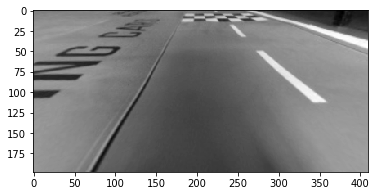

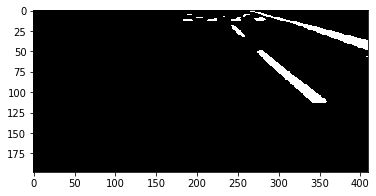

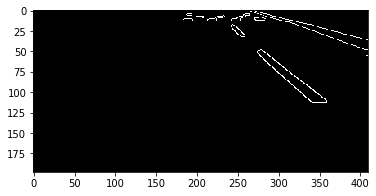

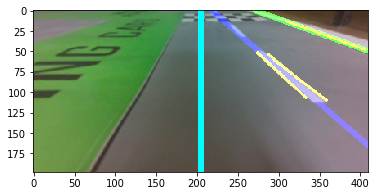

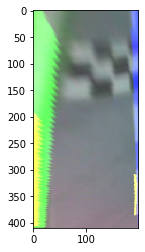

In [486]:
# applying pipeline to test images and saving them
im_path = r'C:\Users\vase_\Downloads\jetbot-nano\carnd-p01-simple-lanes\test_images_otput'
im_name = '2.jpg'
test_img = mpimg.imread("test_images/" + im_name)
#plotz(test_img)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
undistorted_img = cv2.remap(test_img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)[110:,:]
#plotz(undistorted_img)
plt.imsave(os.path.join(im_path, "step0.jpg") , undistorted_img)
verts = get_roi_vertices(undistorted_img)
t = 90
# convert to grayscale
gray_img = grayscale(undistorted_img)
plotz(gray_img)
plt.imsave(os.path.join(im_path, "step1.jpg") , gray_img, cmap='gray')
# apply blur
blurred_img = gaussian_blur(gray_img, 5)
#plotz(blurred_img)
plt.imsave(os.path.join(im_path, "step2.jpg") , blurred_img, cmap='gray')
# top down vuie bipass
binary, warp_mtx, unwarp_mtx = corners_unwarp(blurred_img)
#plotz(binary)
plt.imsave(os.path.join(im_path, "step3.jpg") , binary, cmap='gray')
# treshold
_,th1 = cv2.threshold(blurred_img,180,255,cv2.THRESH_BINARY)
plotz(th1)
# canny image on top of blur
canny_img = canny(th1, t, t*2)
plotz(canny_img)
plt.imsave(os.path.join(im_path, "step4.jpg") , canny_img, cmap='gray')
# apply ROI mask to canny
#masked_canny = region_of_interest(canny_img, verts)
#plotz(masked_canny)
#plt.imsave(os.path.join(im_path, "step5.jpg") , masked_canny, cmap='gray')
# get lines for canny
lines_canny_img,pot_lines = hough_lines(canny_img, 3, np.pi/180, 60, 40, 10)#50 so 100
# get final image
final_img = draw_car_direction(weighted_img(lines_canny_img, undistorted_img))
plotz(final_img)
topdown,M,Minv = top_down_view(final_img,pot_lines)
plotz(topdown)
plt.imsave(os.path.join(im_path, "step6.jpg") , final_img)

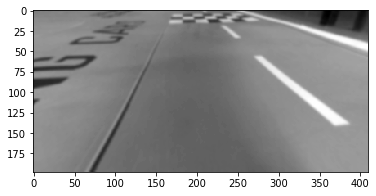

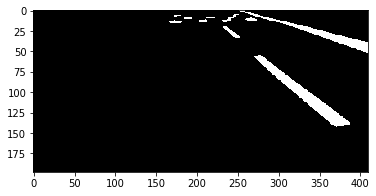

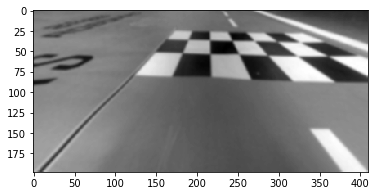

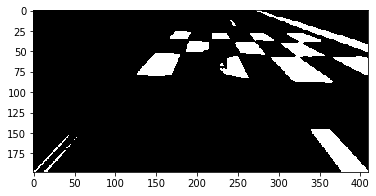

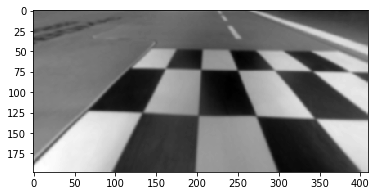

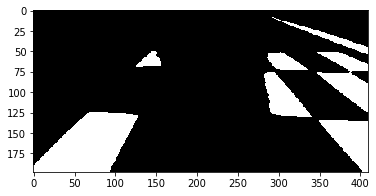

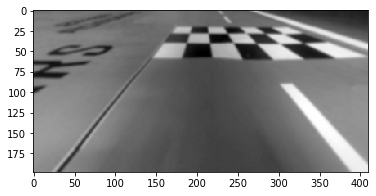

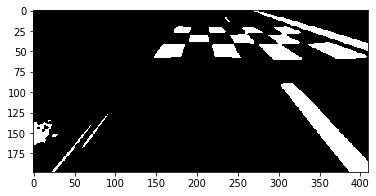

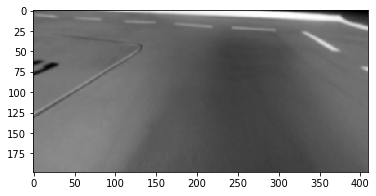

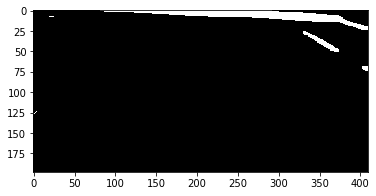

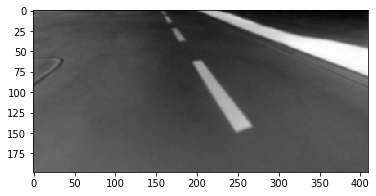

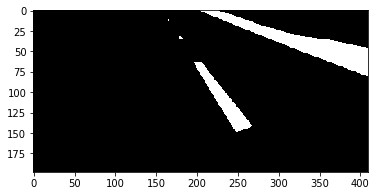

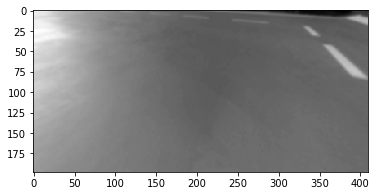

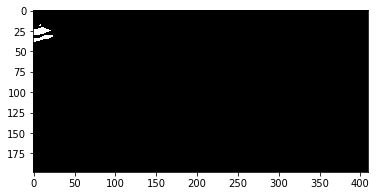

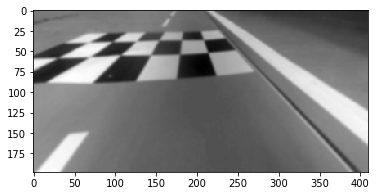

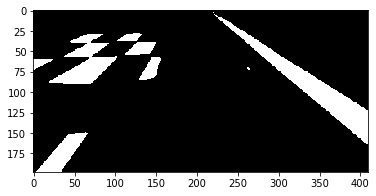

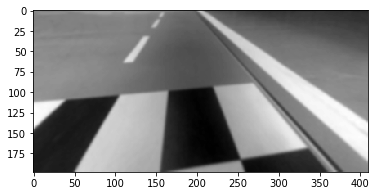

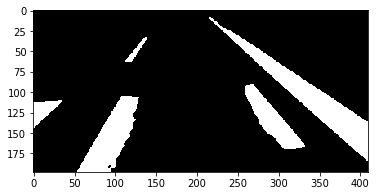

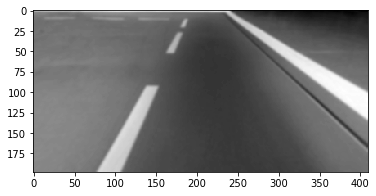

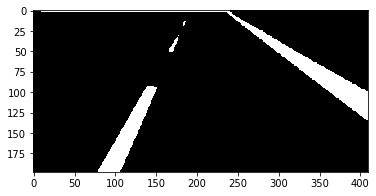

In [95]:
test_img_list = os.listdir("test_images/")
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
for im_name in test_img_list[20:30]:
    test_img = mpimg.imread("test_images/" + im_name)
    undistorted_img = cv2.remap(test_img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)[110:,:]
    gray_img = grayscale(undistorted_img)
    blurred_img = gaussian_blur(gray_img, 5)
    _,th1 = cv2.threshold(blurred_img,180,255,cv2.THRESH_BINARY)
    plotz(blurred_img)
    plotz(th1)